In [138]:
import kagglehub 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.subplots as sp
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import normal_ad
import statsmodels.api as sm
from scipy.stats import anderson
from statsmodels.stats.stattools import durbin_watson

In [139]:
path = kagglehub.dataset_download("amineoumous/50-startups-data")

Using Colab cache for faster access to the '50-startups-data' dataset.


In [140]:
startup_df = pd.read_csv(path + "/50_Startups.csv")

startup_df.head(5)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [141]:
startup_df.shape

(50, 5)

In [142]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [143]:
startup_df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [144]:
startup_df.describe(include='object')

,State
count,50
unique,3
top,New York
freq,17


In [145]:
startup_df.isnull().sum()

,0
R&D Spend,0
Administration,0
Marketing Spend,0
State,0
Profit,0


In [146]:
startup_df[startup_df.duplicated(keep=False)]

,R&D Spend,Administration,Marketing Spend,State,Profit


In [147]:
df = startup_df.copy()

In [148]:
cat_col = ['State']

encoder = OneHotEncoder(sparse_output=False)

encoded = encoder.fit_transform(df[cat_col])

encoded_df = pd.DataFrame(
    encoded,
    columns= encoder.get_feature_names_out(cat_col)
)

df = pd.concat([df.drop(cat_col,axis=1) , encoded_df] , axis= 1)

df.head()

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0.0,0.0,1.0
1,162597.70,151377.59,443898.53,191792.06,1.0,0.0,0.0
2,153441.51,101145.55,407934.54,191050.39,0.0,1.0,0.0
3,144372.41,118671.85,383199.62,182901.99,0.0,0.0,1.0
4,142107.34,91391.77,366168.42,166187.94,0.0,1.0,0.0


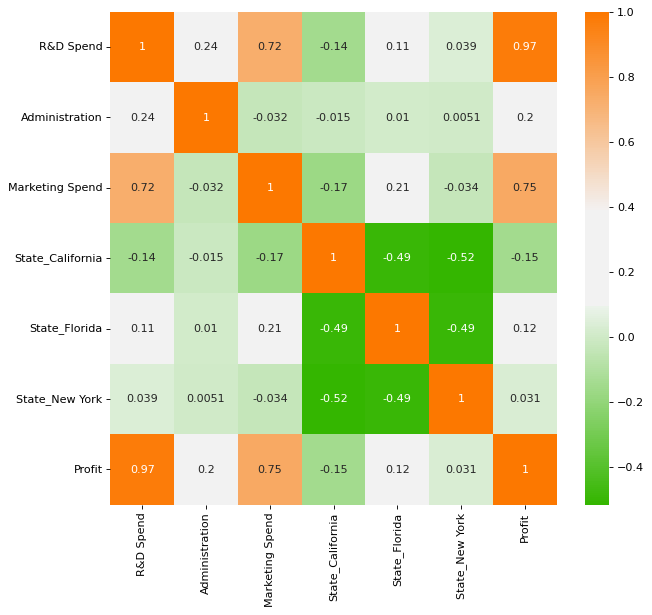

In [149]:
target = 'Profit'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(pd.concat([df.drop(target,axis=1), df[target]],axis=1).corr(), annot=True, cmap=cmap)

In [150]:
X = df.drop([target] , axis=1)
y = df[target]

In [151]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=44)

In [152]:
print('X_train Shape' , X_train.shape)
print('X_test Shape' , X_test.shape)
print('y_train Shape' , y_train.shape)
print('y_test Shape' , y_test.shape)

X_train Shape (40, 6)
X_test Shape (10, 6)
y_train Shape (40,)
y_test Shape (10,)


In [153]:
y_test_actual = y_test 

In [154]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)

X_test_scaled = sc.transform(X_test)

In [155]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

LinearRegression()

In [156]:
train_score = lr.score(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)

print(f'MAE: {metrics.mean_absolute_error(y_train, y_train_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_train, y_train_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)):.2f}')
print(f"R²: {train_score:.2f}")

MAE: 6952.36
MSE: 85824350.48
RMSE: 9264.14
R²: 0.95


In [157]:
pd.DataFrame(data = np.append(lr.intercept_ , lr.coef_), 
             index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,114842.585750
R&D Spend Coef.,37147.433538
Marketing Spend Coef.,3521.662045
State_New York Coef.,628.921335
State_California Coef.,-33.036101
State_Florida Coef.,-597.181276
Administration Coef.,-878.247140


In [158]:
y_pred = lr.predict(X_test_scaled)

MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2_Score = metrics.r2_score(y_test, y_pred)


print(f"MAE: {MAE:.4f}")
print(f"MSE: {MSE:.4f}")
print(f"RMSE: {RMSE:.4f}")
print(f"R2_Score: {R2_Score:.4f}")

MAE: 5565.5778
MSE: 58187920.6861
RMSE: 7628.1007
R2_Score: 0.9525
